In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# maybe we can make long train_data: hsatck it with CGF==1 and CGF == 0 and make 2*n predictions vector 
def uplift_at(y_tr, cgf_tr, uplift_tr, 
              y_ts, cgf_ts, uplift_ts, at=0.5):
    
    tmp_tr = pd.DataFrame( 
        data  = np.vstack((y_tr, cgf_tr, uplift_tr)).transpose(),
        columns = ['target','cgf','uplift']  
        )
    tmp_tr.sort_values('uplift', ascending=False, inplace=True)
    tmp_tr = tmp_tr.head(int(at*tmp_tr.shape[0]))
    real_uplift_tr =  np.round(tmp_tr[tmp_tr['cgf']==0]['target'].mean() - tmp_tr[tmp_tr['cgf']==1]['target'].mean(),4) 
    if y_ts is not None:
            tmp_ts = pd.DataFrame( 
                data  = np.vstack((y_ts, cgf_ts, uplift_ts)).transpose(),
                columns = ['target','cgf','uplift']  
                )
            tmp_ts.sort_values('uplift', ascending=False, inplace=True)
            tmp_ts = tmp_ts.head(int(at*tmp_ts.shape[0]))
            real_uplift_ts =  np.round(tmp_ts[tmp_ts['cgf']==0]['target'].mean() - tmp_ts[tmp_ts['cgf']==1]['target'].mean(),4)
        
    return real_uplift_tr, real_uplift_ts

In [3]:
def offline_simulate_res(X_train, y_train, seed_split, seed_algo, parms_array):
    # 1. split 
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                               test_size=0.3,
                                               random_state=seed_split,
                                               shuffle=True,
                                               stratify=X_train['CONTROL_GROUP_FLG'])
    # 2.1 set params
    xgb_estimator = xgb.XGBClassifier( max_depth = int(parms_array[0]), 
                                       n_estimators = int(parms_array[1]),
                                       learning_rate = parms_array[2],
                                       min_child_weight = int(parms_array[3]),
                                       objective='binary:logistic',
                                       seed = seed_algo)
    # 3. Fit.
    xgb_estimator.fit(X_tr, y_tr)
    
    # 4. Get feature importance
    importance_xgb = pd.DataFrame(
        data = {
                'Feature': X_tr.columns.tolist(),
                'Importance': xgb_estimator.feature_importances_
        })
    top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(30)

    # 5. estimate probs
    prob_tr_xgb_0 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
    prob_tr_xgb_1 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
    uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1

    prob_val_xgb_0 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
    prob_val_xgb_1 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
    uplift_val_xgb = prob_val_xgb_0 - prob_val_xgb_1

    # 5. Save results
    uplift_tr_xgb, uplift_ts_xgb = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                                            y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_xgb, 
                                            at=0.47)
    
    return  uplift_tr_xgb,  uplift_ts_xgb, top_imp_feat

In [4]:
# LOAD TRAIN: 
train = pd.read_csv('test_data/test_data_05_2018/TRAIN_PROCESSED.csv')
identity = ['CONTRACT_REF','CLIENT_ID','SCENARIO_NAME_UNI', 'START_DATE']
train.set_index(identity, inplace=True)
train.head(3)

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.00,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.00,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
274-P-67223249,104216626,UVEL_5,2017-01-23,0,407.44,3.0,1.0,2.0,0.0,31000.0,1.0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1


In [5]:
round(np.mean(train['target']),4)

0.0445

In [6]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train.drop(['target'], axis=1), 
                                            y_train = train['target'], 
                                            seed_split = 8373,
                                            seed_algo = 5993,
                                            parms_array = [3,100,0.1,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

Uplift on train =  0.0441
Uplift on test =  0.0397
Wall time: 32.5 s


In [7]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train.drop(['target'], axis=1), 
                                            y_train = train['target'], 
                                            seed_split = 30382,
                                            seed_algo = 7305,
                                            parms_array = [3,20,0.5,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

Uplift on train =  0.0393
Uplift on test =  0.0447
Wall time: 7.71 s


In [74]:
# parms_array = [3,100,0.1,1] : 
test_1 = [ 0.0406, 0.04, 0.0408, 0.036, 0.0368,  0.0421, 0.0431]

# parms_array = [4,200,0.05,1]
test_2 = [0.0413,  0.0499,  0.0382, 0.0401, 0.0436, 0.0307, 0.0402]

# parms_array = [2,20,0.5,1]
test_3 = [0.0377,  0.0425, 0.038,  0.041,  0.035,  0.0419, 0.036, 0.0458]

In [75]:
print(round(np.mean(test_1),3))
print(round(np.mean(test_2),3))
print(round(np.mean(test_3),3))

0.04
0.041
0.04


In [77]:
good_feat.append(feat_imp)

In [130]:
#feat_imp

In [105]:
good_feat_list = [ feat_tab['Feature'].values.tolist() for  feat_tab in good_feat]
good_feat_list = [ x for feat_list in good_feat_list for x in feat_list]

In [106]:
good_feat_list = [ x for feat_list in good_feat_list for x in feat_list]

In [125]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train[[ x for x in set(good_feat_list)]],
                                            y_train = train['target'], 
                                            seed_split = 173482,
                                            seed_algo = 14121432,
                                            parms_array = [3,100,0.1,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

Uplift on train =  0.0452
Uplift on test =  0.0394
Wall time: 13.6 s


In [126]:
# parms_array = [3,100,0.1,1]
test_4 = [0.0438, 0.0322,  0.0357, 0.0434, 0.0446, 0.0417,  0.0409, 0.0394]

In [127]:
print(round(np.mean(test_4),3))

0.04


In [129]:
# SAVE top inport features
print(len(set(good_feat_list)))
with open("./test_data_04_2018/top_feat_list.bin", "wb") as fp:
    pickle.dump(set(good_feat_list), fp)

47


In [8]:
# LOAD TEST: 
test = pd.read_csv('test_data/test_data_05_2018/TEST_PROCESSED.csv')
identity_test = ['CONTRACT_REF','CLIENT_ID', 'START_DATE']
test.set_index(identity_test, inplace=True)
test.head(3)

,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,MAX_DB_180,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,,,,,,,,
271-P-00303161,101947485,2018-04-26,0,304.83,3,3.0,1.0,0,20000,1.000000,16.000000,0.0,...,208.0,207.0,NaN,NaN,NaN,NaN,0.0,6.0,0.0,7.0
271-P-00687159,105173333,2018-04-26,0,0.00,1,1.0,0.0,406900,N,0.268173,13.662596,0.0,...,8400.0,8400.0,195.0,164.0,NaN,NaN,0.0,6.0,1.0,7.0
271-P-00559853,101863520,NaN,0,0.00,2,2.0,0.0,N,RUR,0.268173,13.662596,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train.head()

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,MAX_DB_360,MAX_CR_180,MAX_CR_360,LAST_DB,LAST_CR,CNT_MNT_DB_180,CNT_MNT_DB_360,CNT_MNT_CR_180,CNT_MNT_CR_360,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.00,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.00,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
274-P-67223249,104216626,UVEL_5,2017-01-23,0,407.44,3.0,1.0,2.0,0.0,31000.0,1.0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
273-P-51055302,102113400,Sc_6,2016-12-15,0,45.05,1.0,1.0,0.0,30000.0,50000.0,0.0,16.0,0.0,...,280.5,NaN,NaN,281.0,NaN,0.0,1.0,0.0,0.0,1
271-P-09670370,101989621,UVEL_1,2017-01-19,0,-27803.59,1.0,1.0,0.0,2000.0,10000.0,1.0,16.0,0.0,...,550.0,3000.0,4200.0,242.0,20.0,0.0,2.0,5.0,9.0,1


In [9]:
#test.columns.tolist() == [x for x in train.columns.tolist() if x != 'target']
sum([ (test.columns.tolist()[i] == [x for x in train.columns.tolist() 
                                    if x != 'target'][i])*1.0 for i in range(test.shape[1])]) == 135

True

In [10]:
train = shuffle(train, random_state=41)

In [11]:
#train.drop(['AGE','CL_AMT_ZP', 'CL_AMT_DOP', 'FL_PENS'], axis=1, inplace=True)
test.drop(['AGE','CL_AMT_ZP', 'CL_AMT_DOP', 'FL_PENS'], axis=1, inplace=True)

In [43]:
%%time
# MODEL 
xgb_estimator = xgb.XGBClassifier( max_depth = 3, 
                                   n_estimators = 100,
                                   learning_rate = 0.1,
                                   min_child_weight = 1,
                                   objective='binary:logistic',
                                   seed = 42)

xgb_estimator.fit(X=train[cols].drop(['target'], axis=1), 
                  y=train['target'])

Wall time: 5.77 s


In [35]:
train[cols].head()

,,,,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CONTR_STATUS_DT_N,CONTROL_GROUP_FLG,LAST_CARD_STATUS_DT_N,BAL,CARD_CONTR_COUNT_0,LAST_CR,MAX_CR_360,LAST_DB,LIM_AVG_N_POS_CHANGE,MAX_DB_360,FL_GOLD,LIM_RECENT,REP_POPULATION,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,
271-P-38210719,104470499,Sc_4,2016-12-16,0.41,297,0,283,45.37,3.0,NaN,NaN,NaN,0.062500,NaN,1.0,200000.0,356400.0,0
271-P-83546488,105000072,POS_2,2017-05-06,4435.64,439,0,406,-52755.92,3.0,NaN,NaN,NaN,0.000000,NaN,1.0,200000.0,0.0,0
271-P-57970656,105187925,UVEL_5,2017-05-03,5000.00,435,0,403,722.37,2.0,NaN,NaN,NaN,0.000000,NaN,0.0,290000.0,406900.0,1
271-P-24982966,104596259,POS_3,2017-02-23,5570.92,367,1,9,-85742.58,5.0,2.0,9300.0,298.0,0.047619,1765.0,1.0,170000.0,979800.0,1
271-P-84271144,103413979,POS_2,2017-03-29,0.00,401,1,398,0.00,1.0,NaN,NaN,NaN,0.000000,NaN,0.0,20000.0,416200.0,0


In [44]:
test[[ f for f in cols if f !='target']].head(3)

,,,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CONTR_STATUS_DT_N,CONTROL_GROUP_FLG,LAST_CARD_STATUS_DT_N,BAL,CARD_CONTR_COUNT_0,LAST_CR,MAX_CR_360,LAST_DB,LIM_AVG_N_POS_CHANGE,MAX_DB_360,FL_GOLD,LIM_RECENT,REP_POPULATION
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,
271-P-00303161,101947485,2018-04-26,0.52,794,0,224,304.83,3,NaN,NaN,NaN,0.034483,207.0,0.0,160000.0,511000.000000
271-P-00687159,105173333,2018-04-26,8351.83,794,0,791,0.00,1,NaN,164.0,NaN,0.000000,8400.0,1.0,150000.0,21326.000000
271-P-00559853,101863520,NaN,0.00,793,0,98,0.00,2,NaN,NaN,NaN,0.000000,NaN,0.0,30000.0,398942.810529


In [45]:
#test['MAX_DB_360'].values[0:20]

In [46]:
#train['MAX_DB_360'].values

In [47]:
#np.log(train[ 'LAST_CONTR_STATUS_DT_N']+1).hist();

In [48]:
#np.log(test[ 'LAST_CONTR_STATUS_DT_N']+1).hist();

In [49]:
#cols = [ f for f in top_imp_feat['Feature'].values if f not in ['AGE', 'SUM_DB_360', 'SUM_CR_360', 'CL_AMT_DOP',
#                                                         'CNT_MNT_CR_360', 'CL_AMT_ZP']]

In [51]:
# importance_xgb = pd.DataFrame(
#         data = {
#                 'Feature': train.drop(['target'], axis=1).columns.tolist(),
#                 'Importance': xgb_estimator.feature_importances_
#         })
# top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(20)
# print(top_imp_feat.head(20))

In [57]:
train = train[cols]
test = test[[ f for f in cols if f !='target']]

In [53]:
test['CONTROL_GROUP_FLG']

CONTRACT_REF    CLIENT_ID  START_DATE
271-P-00303161  101947485  2018-04-26    0
271-P-00687159  105173333  2018-04-26    0
271-P-00559853  101863520  NaN           0
271-P-02328844  101839082  2018-04-26    0
271-P-02926365  101737216  2018-04-26    0
271-P-03418131  105044990  2018-04-26    0
271-P-04427131  102385209  2018-04-26    0
271-P-04089931  103497602  2018-04-26    0
271-P-00498052  104484816  2018-04-26    0
271-P-01115176  104752201  NaN           0
271-P-06791518  103788071  2018-04-26    0
271-P-06792755  103652461  NaN           0
271-P-05023525  101925074  NaN           0
271-P-06003195  102933084  2018-04-26    0
271-P-06457607  103241179  2018-04-26    0
271-P-01067344  104938414  2018-04-26    0
271-P-02247002  105105241  NaN           0
271-P-01526588  102137451  2018-04-26    0
271-P-04568223  105067749  NaN           0
271-P-04681026  102786668  2018-04-26    0
271-P-03840524  102276099  2018-04-26    0
271-P-05420275  104677114  2018-04-26    0
271-P-00394244  

In [58]:
test.head()

,,,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CONTR_STATUS_DT_N,CONTROL_GROUP_FLG,LAST_CARD_STATUS_DT_N,BAL,CARD_CONTR_COUNT_0,LAST_CR,MAX_CR_360,LAST_DB,LIM_AVG_N_POS_CHANGE,MAX_DB_360,FL_GOLD,LIM_RECENT,REP_POPULATION
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,
271-P-00303161,101947485,2018-04-26,0.52,794,0,224,304.83,3,NaN,NaN,NaN,0.034483,207.0,0.0,160000.0,511000.000000
271-P-00687159,105173333,2018-04-26,8351.83,794,0,791,0.00,1,NaN,164.0,NaN,0.000000,8400.0,1.0,150000.0,21326.000000
271-P-00559853,101863520,NaN,0.00,793,0,98,0.00,2,NaN,NaN,NaN,0.000000,NaN,0.0,30000.0,398942.810529
271-P-02328844,101839082,2018-04-26,284945.00,794,0,64,670.22,5,29.0,285000.0,18.0,0.000000,30000.0,1.0,150000.0,28937.000000
271-P-02926365,101737216,2018-04-26,5128.10,794,0,202,-55474.52,4,9.0,13520.0,64.0,0.034483,19870.0,1.0,150000.0,398942.810529


In [59]:
train.head()

,,,,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CONTR_STATUS_DT_N,CONTROL_GROUP_FLG,LAST_CARD_STATUS_DT_N,BAL,CARD_CONTR_COUNT_0,LAST_CR,MAX_CR_360,LAST_DB,LIM_AVG_N_POS_CHANGE,MAX_DB_360,FL_GOLD,LIM_RECENT,REP_POPULATION,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,
271-P-38210719,104470499,Sc_4,2016-12-16,0.41,297,0,283,45.37,3.0,NaN,NaN,NaN,0.062500,NaN,1.0,200000.0,356400.0,0
271-P-83546488,105000072,POS_2,2017-05-06,4435.64,439,0,406,-52755.92,3.0,NaN,NaN,NaN,0.000000,NaN,1.0,200000.0,0.0,0
271-P-57970656,105187925,UVEL_5,2017-05-03,5000.00,435,0,403,722.37,2.0,NaN,NaN,NaN,0.000000,NaN,0.0,290000.0,406900.0,1
271-P-24982966,104596259,POS_3,2017-02-23,5570.92,367,1,9,-85742.58,5.0,2.0,9300.0,298.0,0.047619,1765.0,1.0,170000.0,979800.0,1
271-P-84271144,103413979,POS_2,2017-03-29,0.00,401,1,398,0.00,1.0,NaN,NaN,NaN,0.000000,NaN,0.0,20000.0,416200.0,0


In [60]:
prob_tr_xgb_0 = xgb_estimator.predict_proba(train.drop([ 'target','CONTROL_GROUP_FLG'], axis=1).\
                                            assign(CONTROL_GROUP_FLG = 0)[train.drop(['target'], axis=1).columns])[:,1]
prob_tr_xgb_1 = xgb_estimator.predict_proba(train.drop([ 'target','CONTROL_GROUP_FLG'], axis=1).\
                                            assign(CONTROL_GROUP_FLG = 1)[train.drop(['target'], axis=1).columns])[:,1]
uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1


prob_ts_xgb_0 = xgb_estimator.predict_proba(test.drop('CONTROL_GROUP_FLG', axis=1).\
                                            assign(CONTROL_GROUP_FLG = 0)[test.columns])[:,1]
prob_ts_xgb_1 = xgb_estimator.predict_proba(test.drop('CONTROL_GROUP_FLG', axis=1).\
                                            assign(CONTROL_GROUP_FLG = 1)[test.columns])[:,1]
uplift_ts_xgb = prob_ts_xgb_0 - prob_ts_xgb_1

In [61]:
u_tr, a = uplift_at(train['target'].values, train['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                    train['target'].values, train['CONTROL_GROUP_FLG'], uplift_tr_xgb, at=0.47)
print(u_tr)
print(a)

0.0426
0.0426


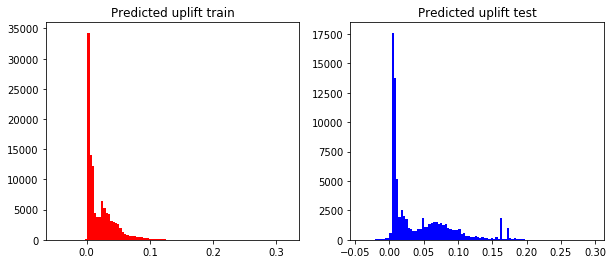

In [62]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_xgb, bins=100, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[1].hist(uplift_ts_xgb, bins=100, color='blue')
axes[1].title.set_text('Predicted uplift test');

In [63]:
test.shape

(79544, 14)

In [64]:
test.head()

,,,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CONTR_STATUS_DT_N,CONTROL_GROUP_FLG,LAST_CARD_STATUS_DT_N,BAL,CARD_CONTR_COUNT_0,LAST_CR,MAX_CR_360,LAST_DB,LIM_AVG_N_POS_CHANGE,MAX_DB_360,FL_GOLD,LIM_RECENT,REP_POPULATION
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,
271-P-00303161,101947485,2018-04-26,0.52,794,0,224,304.83,3,NaN,NaN,NaN,0.034483,207.0,0.0,160000.0,511000.000000
271-P-00687159,105173333,2018-04-26,8351.83,794,0,791,0.00,1,NaN,164.0,NaN,0.000000,8400.0,1.0,150000.0,21326.000000
271-P-00559853,101863520,NaN,0.00,793,0,98,0.00,2,NaN,NaN,NaN,0.000000,NaN,0.0,30000.0,398942.810529
271-P-02328844,101839082,2018-04-26,284945.00,794,0,64,670.22,5,29.0,285000.0,18.0,0.000000,30000.0,1.0,150000.0,28937.000000
271-P-02926365,101737216,2018-04-26,5128.10,794,0,202,-55474.52,4,9.0,13520.0,64.0,0.034483,19870.0,1.0,150000.0,398942.810529


In [66]:
#id_file = pd.read_csv('./test_data_04_2018/MICR_FINAL_IDS.csv', delimiter=';')
#id_file.columns = ['CONTRACT_REF', 'CLIENT_ID']

In [68]:
#id_file.head()

In [70]:
out_data = test.reset_index()[['CONTRACT_REF', 'CLIENT_ID']]
out_data = out_data.assign( Prob_comm = prob_ts_xgb_0,
                            Prob_not_comm =  prob_ts_xgb_1, 
                            Uplift = uplift_ts_xgb)
out_data.sort_values('Uplift', ascending=False, inplace=True)

In [71]:
#out_data = out_data.merge(id_file, how='inner', on = ['CONTRACT_REF', 'CLIENT_ID'])

In [74]:
out_data.head()

,CONTRACT_REF,CLIENT_ID,Prob_comm,Prob_not_comm,Uplift
75843,271-P-35564605,109715371,0.514494,0.219042,0.295452
29058,271-P-43992301,102169062,0.452077,0.176457,0.275620
6700,274-P-43451344,104208686,0.520147,0.254818,0.265330
37722,271-P-25402238,112115633,0.396934,0.139652,0.257282
72800,271-P-86660460,112331218,0.378450,0.128144,0.250306


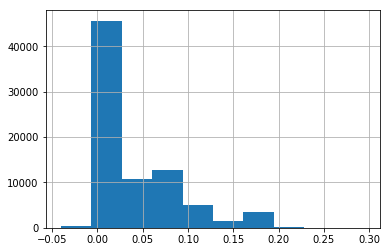

In [76]:
out_data['Uplift'].hist();

In [77]:
print(out_data.shape)

(79544, 5)


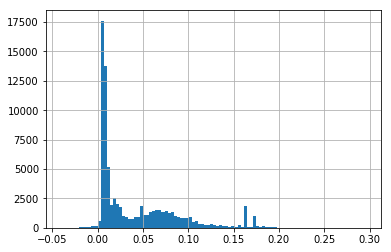

In [78]:
out_data['Uplift'].hist(bins=100);

In [91]:
a = out_data['Uplift'] > 0.02
np.sum(a)

37403

In [93]:
out_data.head(30)

,CONTRACT_REF,CLIENT_ID,Prob_comm,Prob_not_comm,Uplift
75843,271-P-35564605,109715371,0.514494,0.219042,0.295452
29058,271-P-43992301,102169062,0.452077,0.176457,0.275620
6700,274-P-43451344,104208686,0.520147,0.254818,0.265330
37722,271-P-25402238,112115633,0.396934,0.139652,0.257282
72800,271-P-86660460,112331218,0.378450,0.128144,0.250306
47747,271-P-62278020,112422418,0.477516,0.227702,0.249814
66592,271-P-61266851,104451560,0.417385,0.169243,0.248142
66802,271-P-05829270,113967900,0.449070,0.203404,0.245666
55809,271-P-14820697,104842017,0.397526,0.154304,0.243222
43052,271-P-22655850,111284990,0.582985,0.341179,0.241805


In [101]:
out_data.drop(['top_ind'], axis=1, inplace=True)

In [107]:
out_data = out_data.sort_values(['Uplift'], ascending=False)

In [108]:
N_sent = 35700
out_data = out_data.assign(top_ind = np.hstack((np.ones(N_sent), np.zeros(out_data.shape[0]-N_sent))))
print(out_data['top_ind'].mean())
print(out_data[out_data['top_ind']==1]['Uplift'].min())
print(out_data[out_data['top_ind']==0]['Uplift'].max())

0.44880820677863825
0.02273801
0.02273801


In [112]:
out_data.head()

,CONTRACT_REF,CLIENT_ID,Prob_comm,Prob_not_comm,Uplift,top_ind
75843,271-P-35564605,109715371,0.514494,0.219042,0.295452,1.0
29058,271-P-43992301,102169062,0.452077,0.176457,0.275620,1.0
6700,274-P-43451344,104208686,0.520147,0.254818,0.265330,1.0
37722,271-P-25402238,112115633,0.396934,0.139652,0.257282,1.0
72800,271-P-86660460,112331218,0.378450,0.128144,0.250306,1.0


In [113]:
# shuffle data 
out_data = shuffle(out_data, random_state=17)

In [119]:
N_group = 5100
SCEN = pd.Series( ['UVEL_1']*N_group + ['UVEL_3']*N_group  + ['UVEL_4']*N_group + ['POS_2']*N_group + \
               ['ATM_1']*N_group + ['ATM_3']*N_group + ['CG']*N_group) 
                 #+ ['not_sent']*(test.shape[0]-N_sent))
SCEN = shuffle(SCEN, random_state=67)
print( len(SCEN) == N_sent)

True


In [120]:
SCEN.value_counts()
#SCEN[0:100]

ATM_1     5100
POS_2     5100
UVEL_1    5100
UVEL_4    5100
UVEL_3    5100
ATM_3     5100
CG        5100
dtype: int64

In [121]:
out_data.head()

,CONTRACT_REF,CLIENT_ID,Prob_comm,Prob_not_comm,Uplift,top_ind
61775,271-P-28702295,103310496,0.035427,0.015484,0.019944,0.0
12348,271-P-95208804,103653051,0.113861,0.063521,0.050340,1.0
56301,273-P-98676391,103311549,0.120459,0.091099,0.029360,1.0
55474,274-P-74020323,102726561,0.008449,0.004948,0.003501,0.0
70514,271-P-94519680,104459635,0.017226,0.009075,0.008151,0.0


In [122]:
out_data = out_data.assign(SCEN = ['not_sent']*out_data.shape[0])
out_data['SCEN'][out_data['top_ind']==1] = SCEN.values
#out_data['SCEN'][out_data['top_ind']==0] = 'not_sent'

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [123]:
out_data['SCEN'].value_counts()

not_sent    43844
ATM_1        5100
ATM_3        5100
POS_2        5100
UVEL_1       5100
UVEL_4       5100
UVEL_3       5100
CG           5100
Name: SCEN, dtype: int64

In [124]:
out_data['SCEN'][out_data['top_ind'] == 1].value_counts()

ATM_1     5100
POS_2     5100
UVEL_1    5100
UVEL_4    5100
UVEL_3    5100
ATM_3     5100
CG        5100
Name: SCEN, dtype: int64

In [125]:
out_data = out_data.assign( CGF =  pd.Series([out_data['SCEN'].values == 'CG'])[0])
out_data['CGF'][out_data['SCEN'] == 'not_sent'] = 'not_sent'
out_data['CGF'] = out_data['CGF'].map({'not_sent':-1,
                                        True:1,
                                        False:0})

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [292]:
#out_data.tail(30)

In [126]:
# Checks:
out_data.groupby(['SCEN'])['Uplift'].mean().sort_values(ascending=False)

SCEN
CG          0.080757
UVEL_1      0.080699
POS_2       0.080360
ATM_3       0.079885
UVEL_3      0.079849
ATM_1       0.079276
UVEL_4      0.079106
not_sent    0.007940
Name: Uplift, dtype: float32

In [134]:
out_data.groupby(['SCEN'])['Uplift'].mean()

SCEN
ATM_1       0.079276
ATM_3       0.079885
CG          0.080757
POS_2       0.080360
UVEL_1      0.080699
UVEL_3      0.079849
UVEL_4      0.079106
not_sent    0.007940
Name: Uplift, dtype: float32

In [136]:
out_data.tail(30)

,CONTRACT_REF,CLIENT_ID,Prob_comm,Prob_not_comm,Uplift,top_ind,SCEN,CGF
72457,274-P-65823115,103018570,0.016321,0.008456,0.007865,0.0,not_sent,-1
75109,274-P-09209587,101889429,0.008433,0.004806,0.003627,0.0,not_sent,-1
19991,271-P-20234123,104904316,0.208372,0.139491,0.068880,1.0,UVEL_3,0
49959,271-P-23393413,101648504,0.025462,0.010281,0.015182,0.0,not_sent,-1
57163,271-P-72755660,102478433,0.014522,0.006609,0.007914,0.0,not_sent,-1
56400,271-P-32371673,104360672,0.009484,0.005557,0.003927,0.0,not_sent,-1
27839,271-P-28544790,114516068,0.314800,0.187493,0.127307,1.0,UVEL_3,0
44261,271-P-67852464,103336635,0.009258,0.005278,0.003980,0.0,not_sent,-1
49185,272-P-04323155,104898704,0.092045,0.067821,0.024225,1.0,UVEL_3,0
21990,271-P-69204060,109959795,0.014179,0.005511,0.008668,0.0,not_sent,-1


In [135]:
out_data.to_csv('./test_data/test_data_05_2018/MICR_BASE_FINAL_05_2018.csv', index=False)